In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import descartes
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import warnings

## Event selection

#### Context
From [Reeder et al. 2015](https://doi.org/10.1002/2015GL063125)
- "Here an extreme cold front is deﬁned as one for which the maximum temperatureat 2 m is at least 17◦C lower on the day following the front." 
- "There are 43 extreme cold fronts in the period examined, andthe composites are constructed from the daily averaged ﬁelds (0000, 0600, 1200, and 1800 UTC). The chosenthreshold balances the requirement that the front is extreme with the need for a suﬃciently large sample offronts. Nonetheless, the composites are not very sensitive to the choice ΔT = 17◦C. Choosing ΔT = 15◦C asthe criterion hardly changes the ﬁgures discussed later. If ΔT = 10◦C is chosen as the criterion, the number offronts increases to 168"
- "For example, ofthe 24 most signiﬁcant ﬁres in southeastern Australia (as judged by Mills [2005] and Long [2006]) between 1962 and 2003, 11 have been associated with strong cold fronts (12◦C < ΔT < 17◦C) and 8 with extreme cold fronts (ΔT ≥17◦C)."

From [Engel et al. 2009](https://doi.org/10.1002/qj.1986)
- "For example, virtually everyone killed in the 1983 Ash Wednesday ﬁres were killedwithin 1 h of the passage of a cold front. Similarly, the ﬁreﬁghters at Linton, Victoria in 1998 were killed after a coldfront passed."

#### Scripting

<b>Melbourne</b> - using lat/lons of Melbourne Regional Office weather station similar to [Reeder et al. 2015](https://doi.org/10.1002/2015GL063125).<br>
<b>Genoa</b> - relevant to Black Summer fires that had notable impacts in this region (Source: [Fox-Hughes 2023](https://doi.org/10.1175/WAF-D-23-0007.1)). 

In [2]:
input_lat = -37.4755 
input_lon = 149.5929 
loc_name = 'Genoa' 

# input_lat = -37.65 #-37.81
# input_lon = 145.02 #144.97
# loc_name = 'Melbourne' 

melb_lat = -37.65 #-37.81
melb_lon = 145.02 #144.97

In [3]:
# warnings.simplefilter(action='ignore', category=FutureWarning)
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# fig, ax = plt.subplots(figsize=(9,3))
# ax.set_xlim(144, 150) 
# ax.set_ylim(-39, -37) 

# world.plot(ax=ax, color='lightgrey', alpha=0)
# cx.add_basemap(ax, crs=world.crs.to_string())
# genoa_df = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip([input_lon], [input_lat])])
# genoa_df.plot(ax=ax, markersize=100, color='blue', marker='*', label='Genoa')
# melb_df = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip([melb_lon], [melb_lat])])
# melb_df.plot(ax=ax, markersize=100, color='red', marker='*', label='Melbourne')
# ax.legend(loc='lower right')
# plt.show()

<b>Set up dask</b>

In [3]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39597,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:39527,Total threads: 1
Dashboard: /proxy/41553/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:36483,


2024-09-26 15:36:12,264 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36657'.
2024-09-26 15:36:12,286 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39527'.
2024-09-26 15:36:12,290 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33375'.
2024-09-26 15:36:12,293 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:44753'.
2024-09-26 15:36:12,295 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36045'.
2024-09-26 15:36:12,297 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:41495'.
2024-09-26 15:36:12,298 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40731'.
2024-09-26 15:36:12,300 - distributed.scheduler - WARNING - Received heartbeat from unregistered 

In [37]:
# client.close()

<b>Open ACCESS-ESM1-5 BARPA FFDI and Tmax</b>

In [4]:
ffdi_access_esm1_5_barpa = xr.concat([xr.open_zarr('/g/data/ia39/ncra/fire/AGCD-05i_BOM_ACCESS-ESM1-5_ssp370_r6i1p1f1_BARPA-R_v1-r1_day_FFDI.zarr_old')['FFDI'],\
           xr.open_zarr('/g/data/ia39/ncra/fire/AGCD-05i_BOM_ACCESS-ESM1-5_ssp370_r6i1p1f1_BARPA-R_v1-r1_day_FFDI.zarr')['FFDI']], dim='time')

tasmax_access_esm1_5_barpa_files = []
cmip6_hist = '/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-output/AGCD-05i/BOM/ACCESS-ESM1-5/historical/r6i1p1f1/BARPA-R/v1-r1-ACS-QME-AGCD-1960-2022/day/tasmaxAdjust'
cmip6_ssp370 = '/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-output/AGCD-05i/BOM/ACCESS-ESM1-5/ssp370/r6i1p1f1/BARPA-R/v1-r1-ACS-QME-AGCD-1960-2022/day/tasmaxAdjust'
for i in range(1960,2101):
    tasmax_access_esm1_5_barpa_files.extend(sorted(glob.glob("{}/*{}".format(cmip6_hist, str(i)+'1231.nc'))))
    tasmax_access_esm1_5_barpa_files.extend(sorted(glob.glob("{}/*{}".format(cmip6_ssp370, str(i)+'1231.nc'))))
tasmax_access_esm1_5_barpa = xr.open_mfdataset(tasmax_access_esm1_5_barpa_files)['tasmaxAdjust'].sel(time=slice('2015-01-01','2099-12-31'))

In [9]:
tasmax_timeseries = tasmax_access_esm1_5_barpa.sel(lat=input_lat, lon=input_lon, method='nearest').compute()
tasmax_delta_t_timeseries = tasmax_access_esm1_5_barpa.sel(lat=input_lat, lon=input_lon, method='nearest').diff('time', label='lower').compute()
ffdi_timeseries = ffdi_access_esm1_5_barpa.sel(lat=input_lat, lon=input_lon, method='nearest').compute()

In [7]:
timeseries_df = tasmax_delta_t_timeseries.to_dataframe(name='tasmax_deltat').merge(tasmax_timeseries[:-1].to_dataframe(name='tasmax'), left_index=True, right_index=True).merge(ffdi_timeseries[:-1].to_dataframe(name='ffdi'), left_index=True, right_index=True).drop(columns=['lat', 'lon', 'lat_y', 'lat_x', 'lon_y', 'lon_x']).dropna()

In [8]:
timeseries_df

,tasmax_deltat,tasmax,ffdi
time,,,
2015-01-20 12:00:00,1.960938,20.234375,2.727274
2015-01-21 12:00:00,3.125000,22.195312,4.958015
2015-01-22 12:00:00,0.984375,25.320312,7.309310
2015-01-23 12:00:00,-6.789062,26.304688,4.317889
2015-01-24 12:00:00,0.273438,19.515625,2.321827
...,...,...,...
2099-12-26 12:00:00,0.843750,20.867188,14.577798
2099-12-27 12:00:00,3.593750,21.710938,9.371010
2099-12-28 12:00:00,2.835938,25.304688,8.943654


<b>Slice to GWL</b>

In [96]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f'GWL{GWL} for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:')
    print(get_GWL_syear_eyear('CMIP6', 'ACCESS-ESM1-5', 'r6i1p1f1', 'ssp370', GWL))
    print()

GWL1.2 for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:
[2015 2034]

GWL1.5 for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:
[2023 2042]

GWL2.0 for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:
[2035 2054]

GWL3.0 for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:
[2062 2081]



In [9]:
def gwl_plot(GWL_level):
    sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
    from gwl import get_GWL_timeslice, get_GWL_syear_eyear

    syear, eyear = get_GWL_syear_eyear('CMIP6', 'ACCESS-ESM1-5', 'r6i1p1f1', 'ssp370', GWL_level)
    gwl_ts_df = timeseries_df[(timeseries_df.index > f'{str(syear)}-01-01') & (timeseries_df.index < f'{str(eyear)}-12-31')]
    plt.scatter(gwl_ts_df['ffdi'], gwl_ts_df['tasmax_deltat'], color='black', alpha=0.2)
    plt.xlim([0,110])
    plt.ylim([-25,20])
    
    plt.axhline(y=-17, color='r', linestyle='--', label='Extreme cold front threshold (ΔTmax ≤ -17°C)')
    plt.axhline(y=-12, color='r', linestyle='--', alpha=0.3, label='Strong cold front threshold (ΔTmax ≤ -12°C)')
    
    plt.axvline(x=75, color='b', linestyle='--', label='Extreme fire danger')
    plt.axvline(x=50, color='b', linestyle='--', alpha=0.3, label='Severe fire danger')
    
    plt.xlabel(r'${FFDI}$'+'\n\n'+r'${Source:\ BARPA\ downscaled\ and\ QME\ bias\ corrected\ ACCESS-ESM1-5}$'+'\n' + r'${{GWL:\ {}°C\ ({}-{})}}$'.format(GWL_level, syear, eyear).ljust(94))
    plt.ylabel(r'${ΔT}_{max}$')

    label = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    idx_counter=0
    plt.text(84, 8.5, ' 'r'$\mathbf{Event\ Dates:}$' , fontsize=9)
    for index, row in gwl_ts_df.iterrows():
        if row['tasmax_deltat'] <= -12 and row['ffdi']>=50 and row['ffdi']<=100:
            plt.text(row['ffdi'], row['tasmax_deltat']-0.3, label[idx_counter], fontsize=6)
            plt.text(85, 7-1.5*idx_counter, "{}: {}".format(label[idx_counter], index.strftime('%d-%m-%Y')), fontsize=8)
            idx_counter=idx_counter+1
            print(index.strftime('%d-%m-%Y'))
        
    plt.title(r'$\mathbf{{FFDI\ and\ cold\ front\ co-occurence\ for\ {}\ (GWL\ {}°C)}}$'.format(loc_name, GWL_level) + '\n' +
              r'$\mathbf{{}}_{\mathrm{{using\ ΔTmax\ as\ a\ proxy\ for\ cold\ front\ occurence\ as\ per\ the\ method\ of\ Reeder\ et\ al.\ 2015}}}$')
    plt.legend(framealpha=1, fontsize=8, loc='upper right')
    plt.show()
    plt.clf()
    return

23-12-2024
25-01-2029
27-10-2029


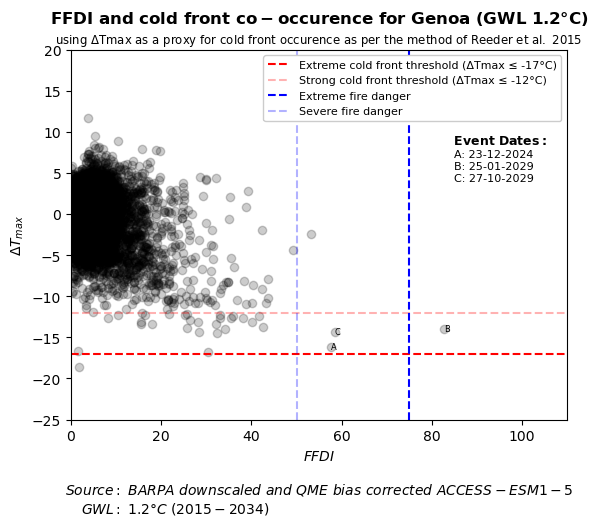

23-12-2024
25-01-2029
27-10-2029


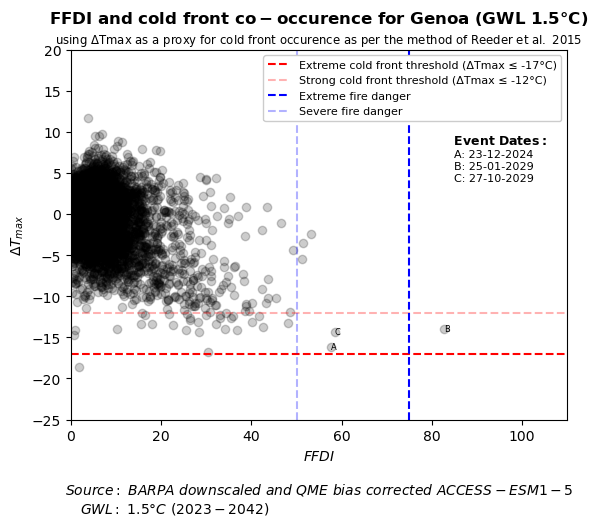

15-12-2048
23-11-2050
07-12-2050
26-12-2050
30-12-2050
17-11-2053


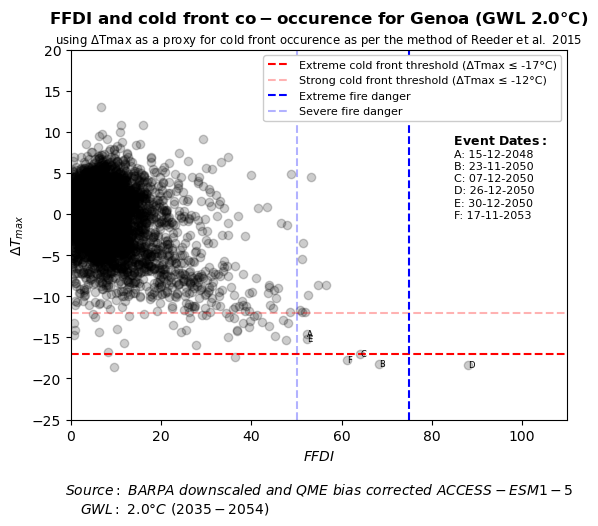

29-10-2064
06-11-2064
22-11-2064
29-11-2064
06-01-2066
17-11-2066
11-11-2067
22-11-2067
30-01-2070
20-11-2070
25-12-2070
02-11-2072
31-10-2073
18-11-2076
30-10-2078
15-11-2078
11-10-2079
11-12-2079
26-01-2080
17-09-2081
17-11-2081


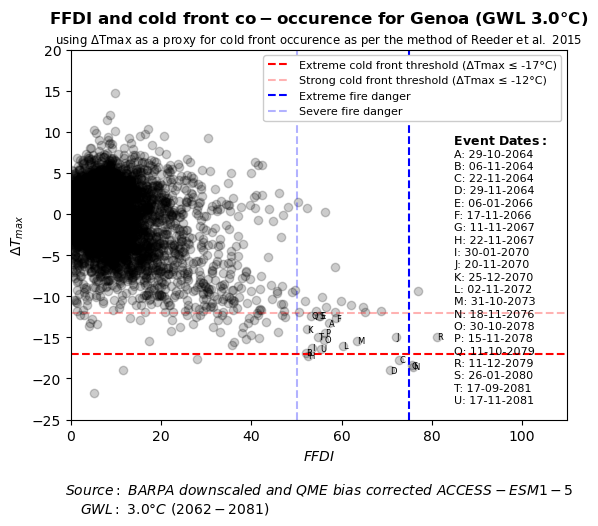

<Figure size 640x480 with 0 Axes>

In [10]:
gwl_plot(1.2)
gwl_plot(1.5)
gwl_plot(2.0)
gwl_plot(3.0)

<b>Plotting relevant heat, fire, drought maps</b>

In [10]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [11]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict

CPU times: user 4min 54s, sys: 47.8 s, total: 5min 42s
Wall time: 9min 17s


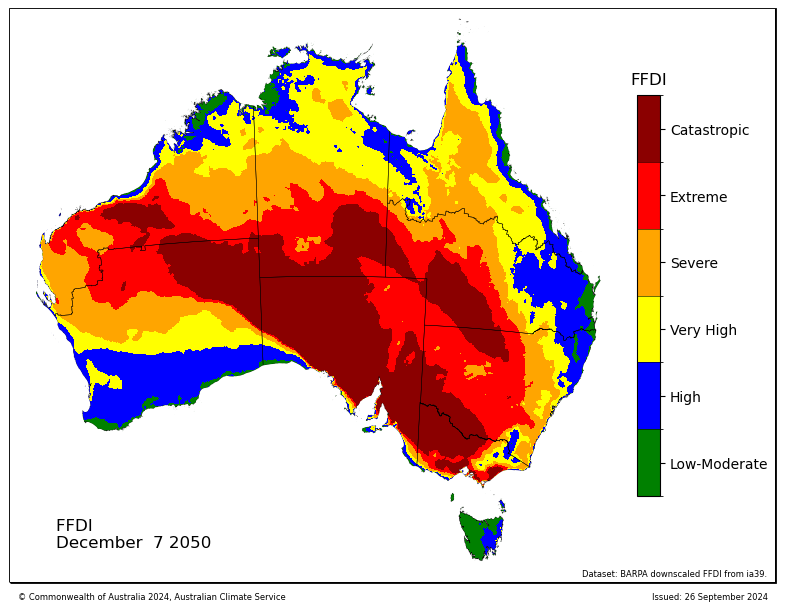

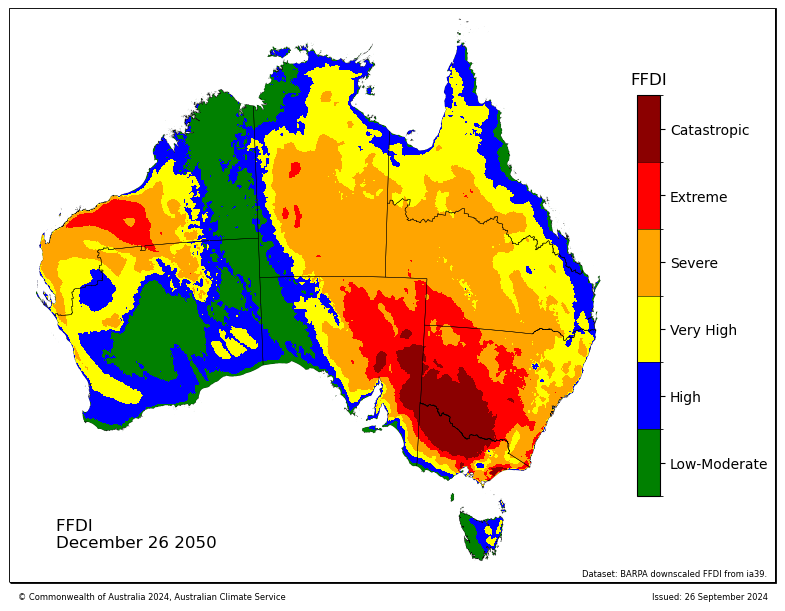

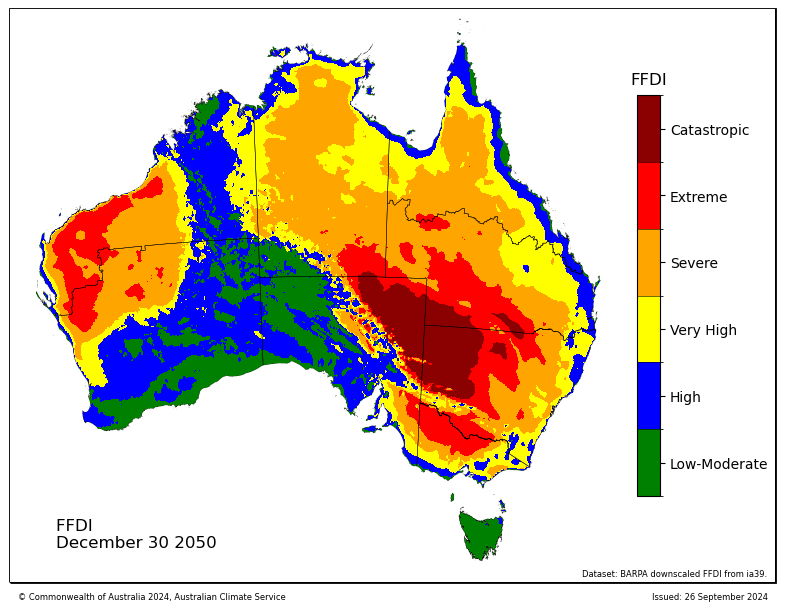

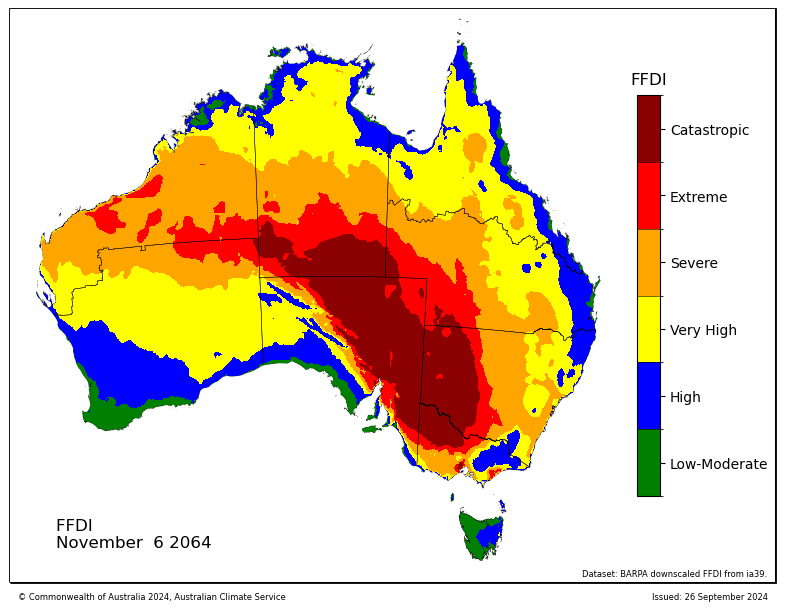

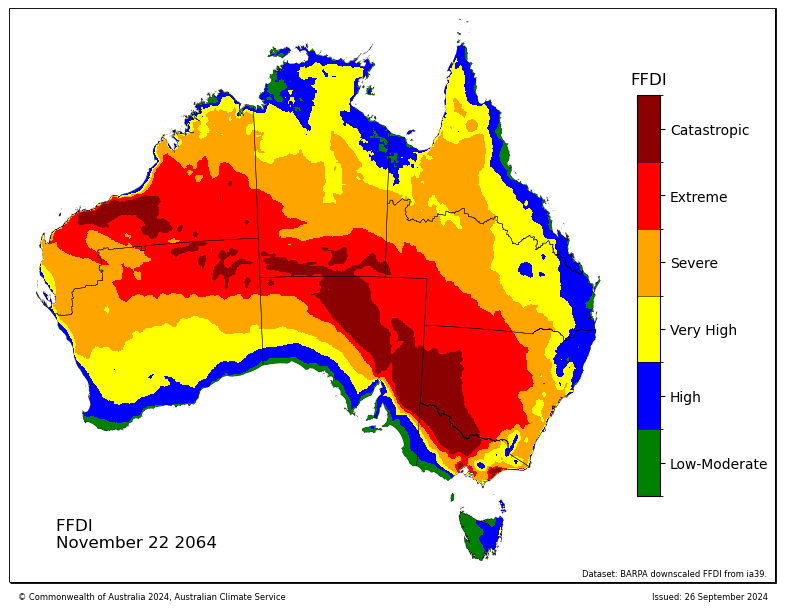

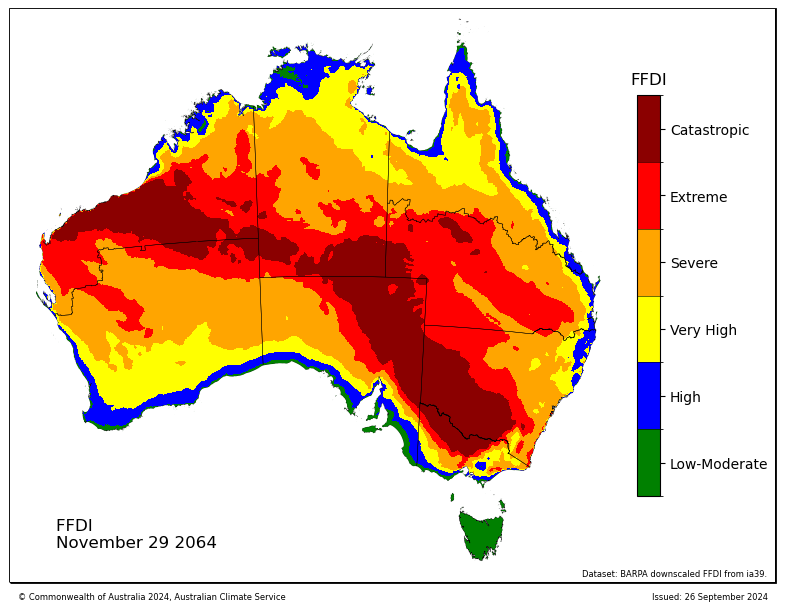

In [26]:
%%time
for plot_date in ['2050-12-7', '2050-12-26', '2050-12-30', '2064-11-6', '2064-11-22', '2064-11-29']:
    plot_xr = ffdi_access_esm1_5_barpa.sel(time=plot_date)[:,:,1].load()
    plot_acs_hazard(data = plot_xr,
                    regions = regions_dict['ncra_regions'],
                    cmap = cmap_dict["ffdi_category"],
                    ticks = [0, 12, 32, 50, 75, 100, 125],
                    tick_labels=['Low-Moderate', 'High', 'Very High', 'Severe', 'Extreme', 'Catastropic'],
                    cbar_label = "FFDI",
                    cbar_extend = "neither",
                    title = "FFDI ",
                    dataset_name = "BARPA downscaled FFDI from ia39.",
                    date_range = (datetime.strptime(plot_date, '%Y-%m-%d')).strftime('%B %e %Y'),
                    contourf = False,
                    contour = False,
                    watermark= None,
                    outfile = f"/g/data/dx2/jb6465/spi_pandora/plots/black_summer_new_plots/FFDI_{plot_date}.png" 
                   );

CPU times: user 1min 47s, sys: 8.49 s, total: 1min 55s
Wall time: 1min 43s


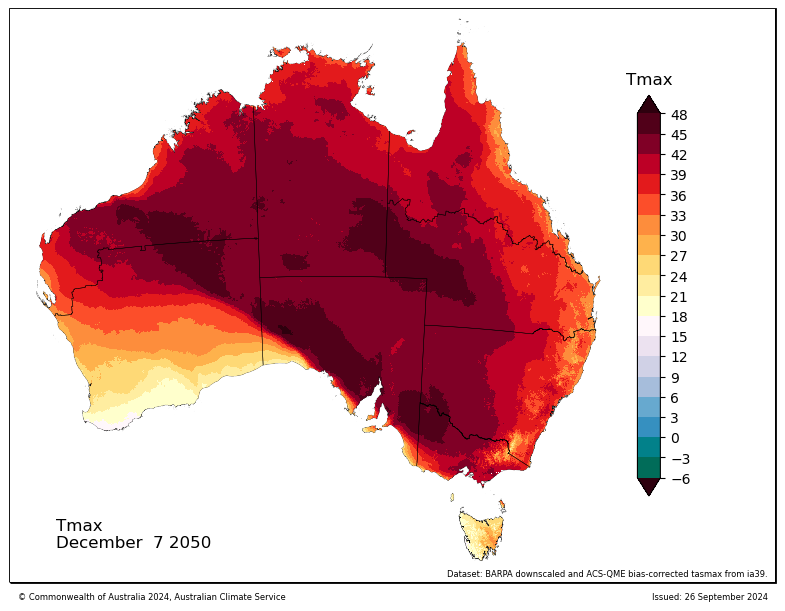

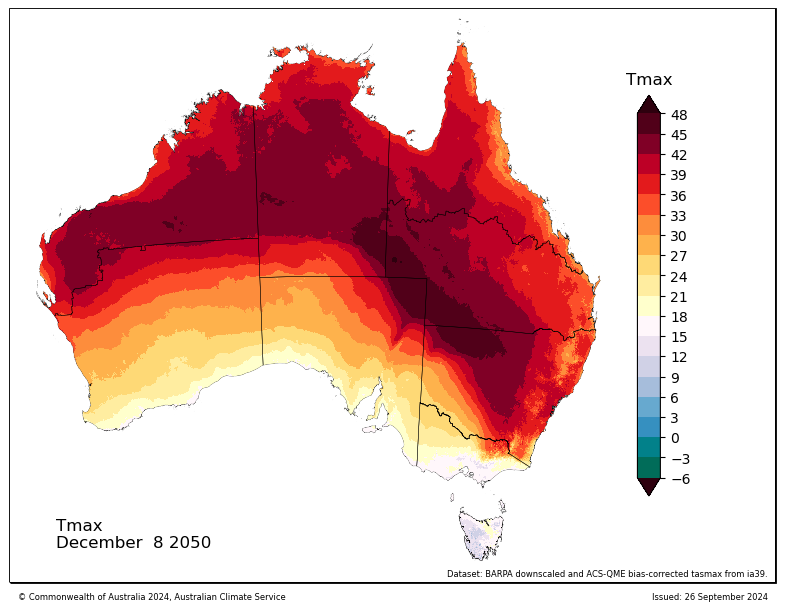

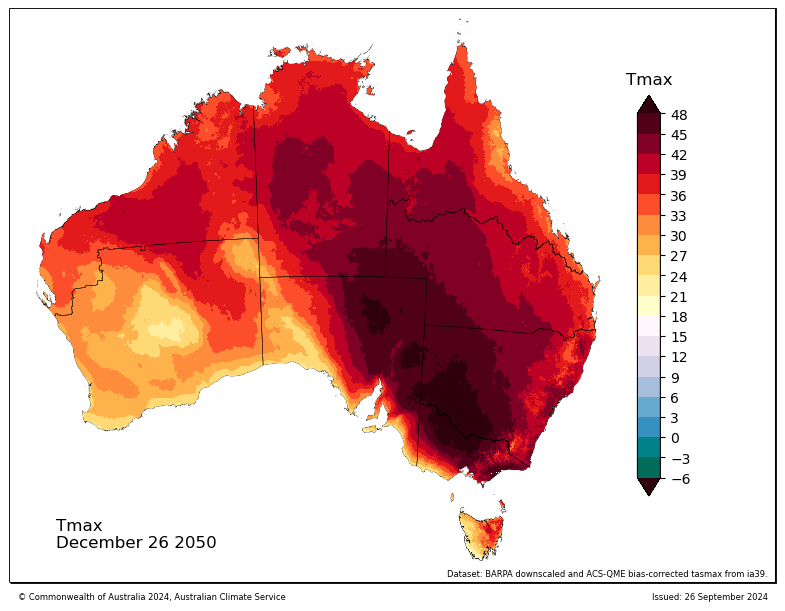

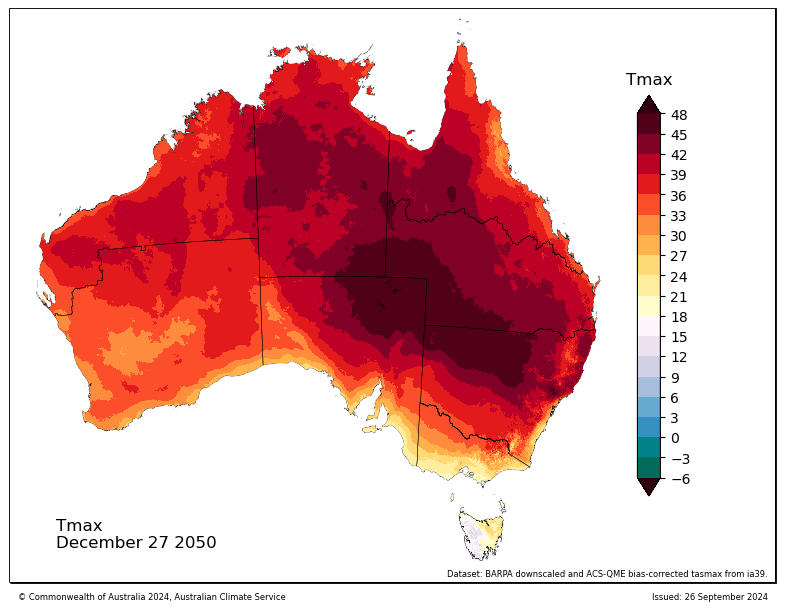

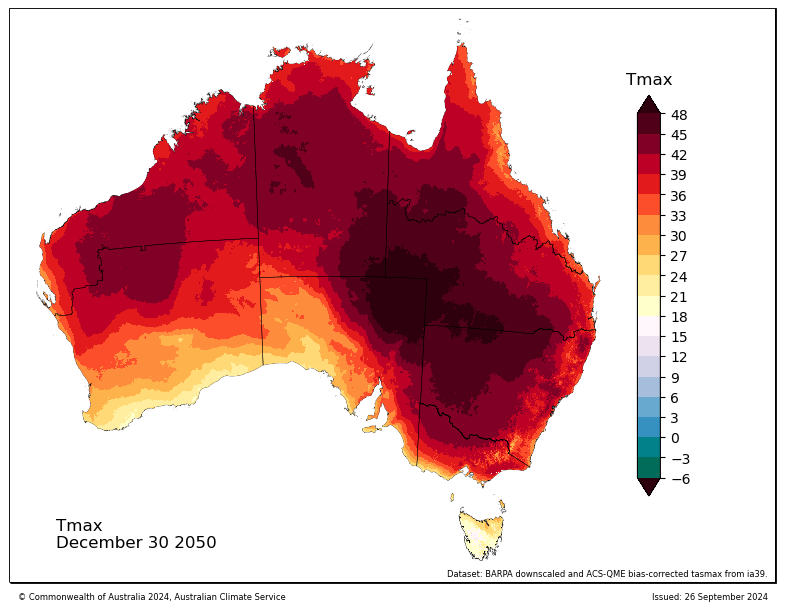

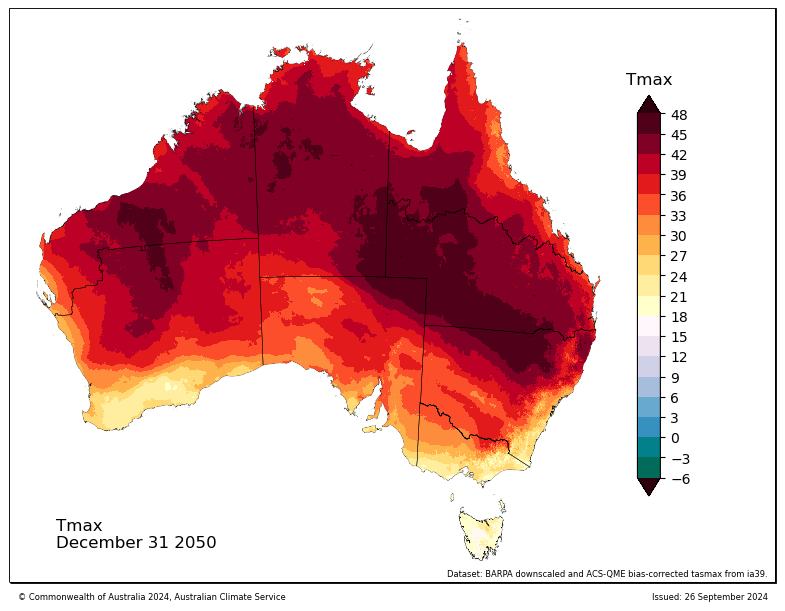

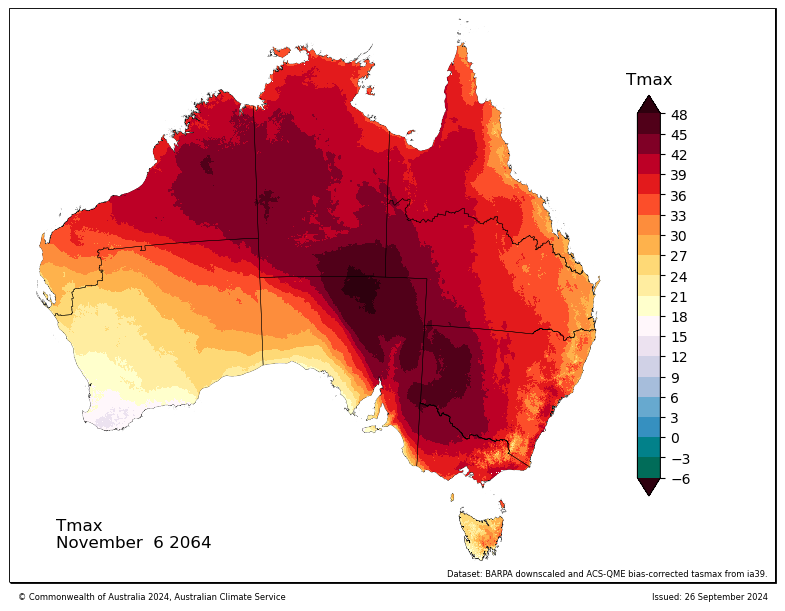

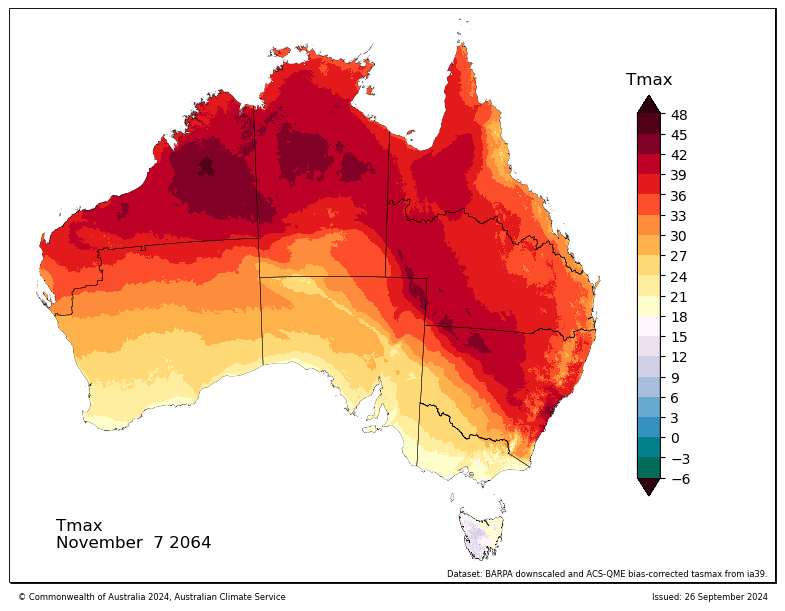

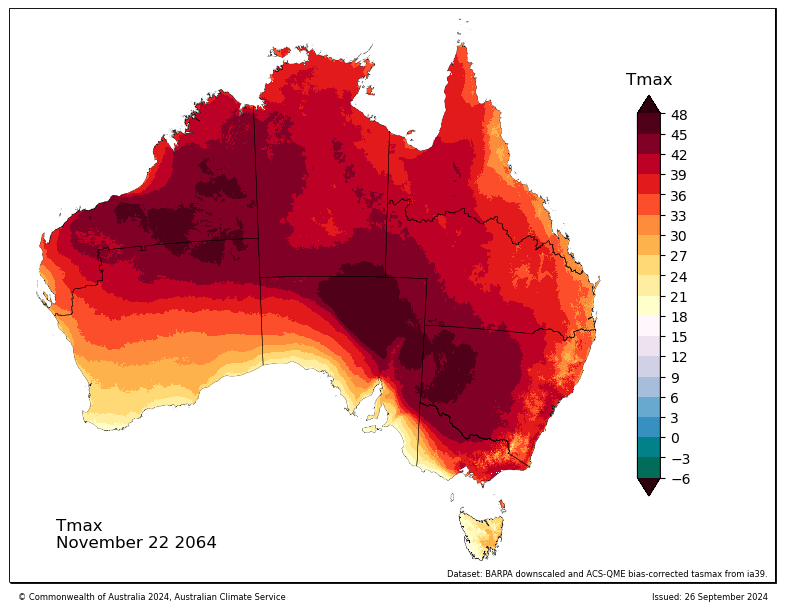

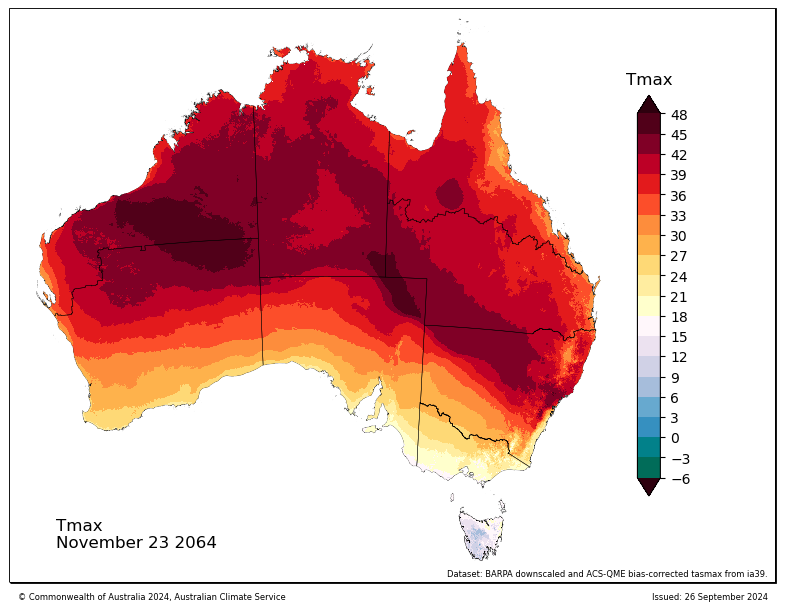

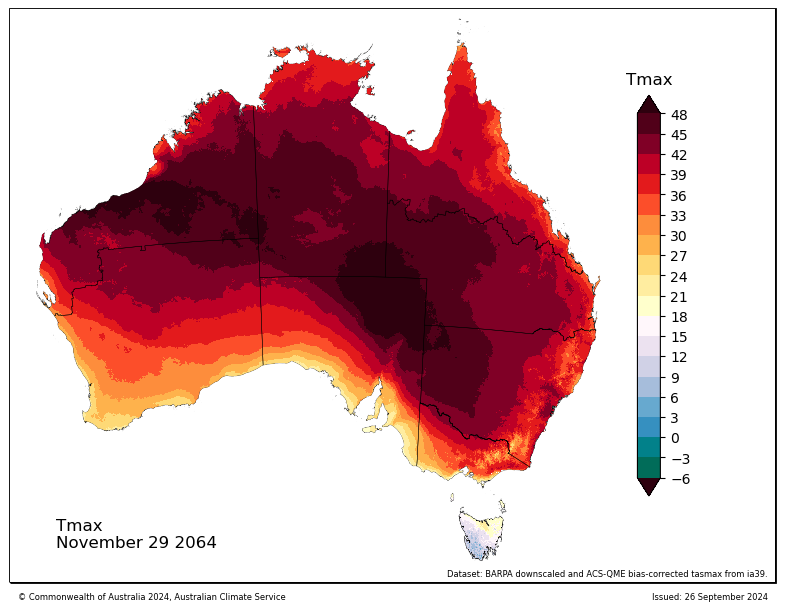

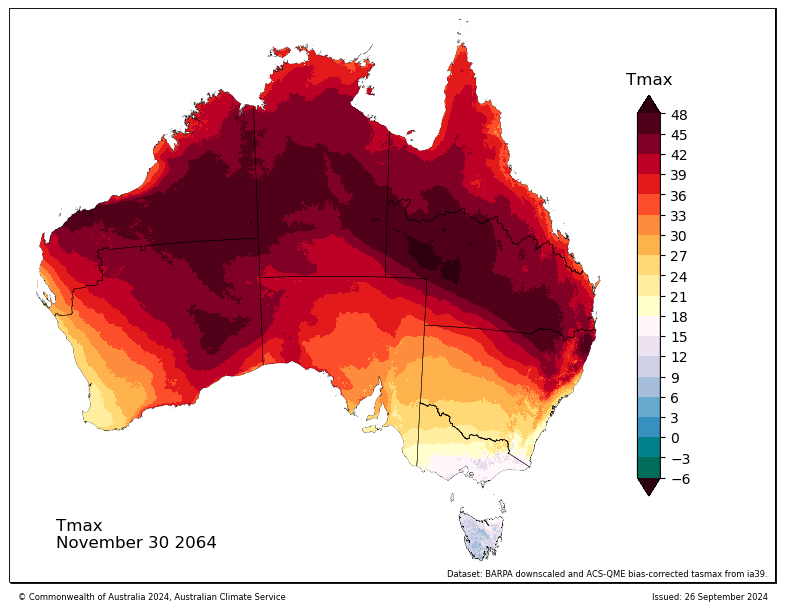

In [28]:
%%time
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

for plot_date in ['2050-12-7', '2050-12-8', '2050-12-26', '2050-12-27', '2050-12-30', '2050-12-31', '2064-11-6', '2064-11-7', '2064-11-22', '2064-11-23', '2064-11-29', '2064-11-30']:
    plot_xr = tasmax_access_esm1_5_barpa.sel(time=plot_date)[0]
    plot_acs_hazard(data = plot_xr,
                    regions = regions_dict['ncra_regions'],
                    cmap = ListedColormap([ '#2E000E','#016C59','#02818A','#3690C0','#67A9CF','#A6BDDB','#D0D1E6',\
                                           '#ECE2F0','#FFF7FB','#FFFFCC', '#FFEDA0','#FED976','#FEB24C',\
                                           '#FD8D3C','#FC4E2A','#E31A1C', '#BD0026','#800026','#510019','#2E000E']),
                    ticks = np.arange(-6, 49, 3),
                    cbar_label = "Tmax",
                    cbar_extend = "both",
                    title = "Tmax",
                    dataset_name = "BARPA downscaled and ACS-QME bias-corrected tasmax from ia39.",
                    date_range = (datetime.strptime(plot_date, '%Y-%m-%d')).strftime('%B %e %Y'),
                    contourf = False,
                    contour = False,
                    watermark= None,
                    outfile = f"/g/data/dx2/jb6465/spi_pandora/plots/black_summer_new_plots/tasmax_{plot_date}.png" 
                   );

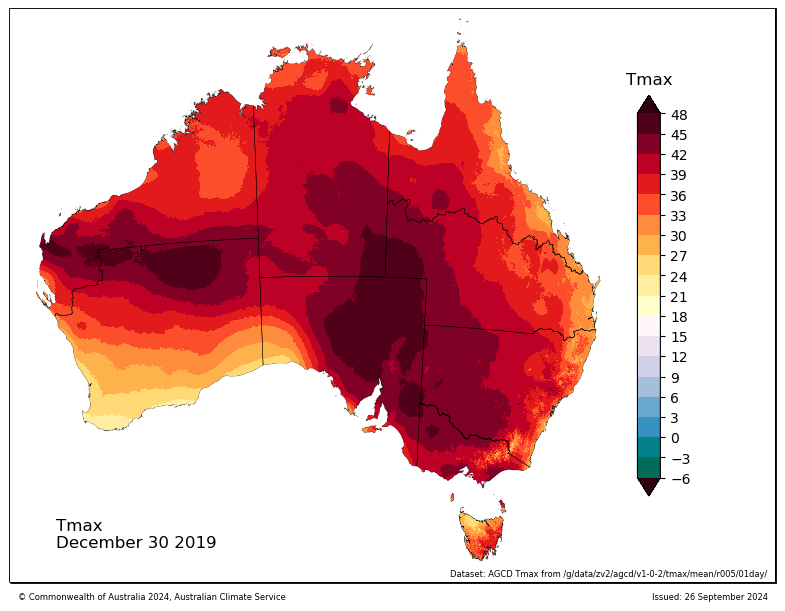

In [32]:
plot_xr = xr.open_dataset('/g/data/zv2/agcd/v1-0-2/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_2019.nc').sel(time='2019-12-30')['tmax'][0]
plot_date = '2019-12-30'
plot_acs_hazard(data = plot_xr,
                regions = regions_dict['ncra_regions'],
                cmap = ListedColormap([ '#2E000E','#016C59','#02818A','#3690C0','#67A9CF','#A6BDDB','#D0D1E6',\
                                       '#ECE2F0','#FFF7FB','#FFFFCC', '#FFEDA0','#FED976','#FEB24C',\
                                       '#FD8D3C','#FC4E2A','#E31A1C', '#BD0026','#800026','#510019','#2E000E']),
                ticks = np.arange(-6, 49, 3),
                cbar_label = "Tmax",
                cbar_extend = "both",
                title = "Tmax",
                dataset_name = "AGCD Tmax from /g/data/zv2/agcd/v1-0-2/tmax/mean/r005/01day/",
                date_range = (datetime.strptime(plot_date, '%Y-%m-%d')).strftime('%B %e %Y'),
                contourf = False,
                contour = False,
                watermark= None,
                outfile = f"/g/data/dx2/jb6465/spi_pandora/plots/black_summer_new_plots/tasmax_{plot_date}.png" 
               );